In [11]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
#export
from exp.nb_05b import *

In [13]:
x_train,y_train,x_valid,y_valid = get_data()
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

In [14]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [29]:
class LR_Find(Callback):
    _order=1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter,self.min_lr,self.max_lr = max_iter,min_lr,max_lr
        self.best_loss = 1e9
        
    def begin_batch(self): 
        if not self.in_train: return
        pos = self.n_iter/self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos
        for pg in self.opt.param_groups: pg['lr'] = lr
            
    def after_step(self):
        if self.n_iter>=self.max_iter or self.loss>self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss

In [30]:
learn = create_learner(get_model, loss_func, data)

In [31]:
run = Runner(cb_funcs=[LR_Find, Recorder])

In [32]:
run.fit(2, learn)

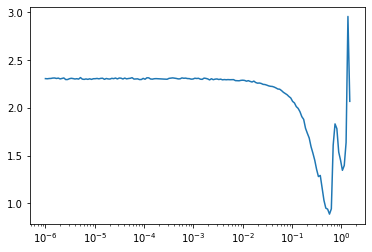

In [27]:
run.recorder.plot(skip_last=5, pgid=-1)

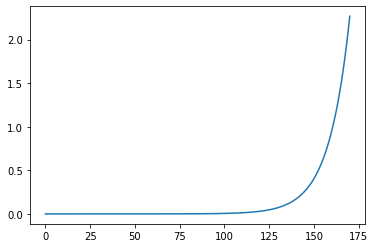

In [28]:
run.recorder.plot_lr()

In [13]:
#export
class SmoothenValue():
    "Creates a smooth moving average for a value (loss, etc)"
    def __init__(self, beta:float)->None:
        "Create smoother for value, beta should be 0<beta<1"
        self.beta,self.n,self.mov_avg = beta,0,0
    
    def add_value(self, val:float)->None:
        "Add current value to calculate updated smoothed value "
        self.n += 1
        self.mov_avg = self.beta * self.mov_avg + (1 - self.beta) * val
        self.smooth = self.mov_avg / (1 - self.beta ** self.n)

In [14]:
smoothener = SmoothenValue(0.98)

In [15]:
smoothener.add_value(4)

In [16]:
smoothener.mov_avg

0.08000000000000007

In [32]:
class Recorder(Callback):
    def begin_fit(self):
        self.lrs = [[] for _ in self.opt.param_groups]
        self.losses = []
        self.smoothener = SmoothenValue(0.9)
        self.smooth_loss = []

    def after_batch(self):
        if not self.in_train: return
        for pg,lr in zip(self.opt.param_groups,self.lrs): lr.append(pg['lr'])
        self.losses.append(self.loss.detach().cpu())
        self.smoothener.add_value(self.loss.detach().cpu())
        self.smooth_loss.append(self.smoothener.smooth)

    def plot_lr  (self, pgid=-1): plt.plot(self.lrs[pgid])
    def plot_loss(self, skip_last=0): plt.plot(self.losses[:len(self.losses)-skip_last])

    def plot(self, skip_last=0, pgid=-1):
        losses = [o.item() for o in self.losses]
        lrs    = self.lrs[pgid]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(lrs[:n], losses[:n])
        
    def plot_smooth(self,skip_last=0, pgid=-1):
        slosses = [o.item() for o in self.smooth_loss]
        lrs    = self.lrs[pgid]
        n = len(slosses)-skip_last
        plt.xscale('log')
        plt.plot(lrs[:n], slosses[:n])

In [ ]:
class LR_Find(Callback):
    _order=1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter,self.min_lr,self.max_lr = max_iter,min_lr,max_lr
        self.best_loss = 1e9
        
    def begin_batch(self): 
        if not self.in_train: return
        pos = self.n_iter/self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos
        for pg in self.opt.param_groups: pg['lr'] = lr
            
    def after_step(self):
        if self.n_iter>=self.max_iter or self.loss>self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss

In [33]:
learn = create_learner(get_model, loss_func, data)
run = Runner(cb_funcs=[LR_Find, Recorder])
run.fit(2, learn)

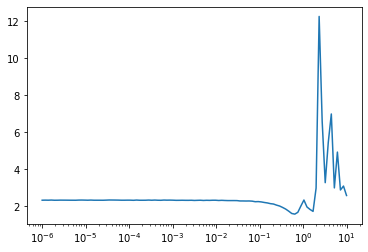

In [34]:
run.recorder.plot()

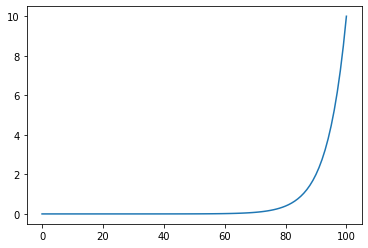

In [35]:
run.recorder.plot_lr()

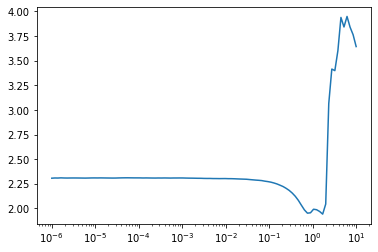

In [36]:
run.recorder.plot_smooth()

In [37]:
learn = create_learner(get_model, loss_func, data)
run = Runner(cb_funcs=[ partial(AvgStatsCallback,accuracy), Recorder])
run.fit(2, learn)

train: [0.671376328125, tensor(0.8063)]
valid: [0.2978099365234375, tensor(0.9172)]
train: [0.29394958984375, tensor(0.9157)]
valid: [0.2386800537109375, tensor(0.9303)]
